#**CHAPTER 3. REPRESENTATION ENGINEERING AND MECHANISTIC CONTROL**
---

##0.REFERENCE

https://chatgpt.com/share/69850bb3-6bac-8012-b265-ab7f7cce933d

##1.CONTEXT

**INTRODUCTION — What this notebook does and why it matters **

This notebook is a controlled synthetic experiment about **representation engineering**—the practice of deliberately manipulating a learned representation (an embedding, a feature map, or an internal activation state) to induce desired behavior in downstream outputs. In the current frontier landscape, this idea appears under multiple names: steering vectors, activation editing, mechanistic control, latent intervention, and related approaches that claim to modify model behavior without retraining. The notebook’s goal is not to endorse these methods. Its goal is to provide a governance-first, finance-literate lens on a basic mechanism: **you can improve a target attribute measured in representation space while simultaneously inducing collateral damage**, often in ways that are easy to miss if you focus on a single proxy metric.

For finance-trained readers, the analogy is immediate. A representation is best understood as a coordinate system that compresses a complex object—text, images, sequences, or structured records—into a vector. In portfolio terms, you can think of that vector as an “exposure profile,” but with a crucial difference: the axes are not designed economic factors; they are learned dimensions with mixed semantics. This is closer to a latent factor model whose factors are not named, not orthogonal, and not guaranteed to be stable across regimes. Representation engineering then becomes the act of applying a deliberate perturbation to that exposure profile—analogous to imposing a factor tilt—on the theory that the tilt will improve a desirable output.

The structural risk is also familiar. In finance, optimizing a return proxy can silently increase tail risk, liquidity risk, leverage, or correlation risk. In representation engineering, optimizing a target proxy can silently change other attributes because the representation encodes multiple coupled signals. This coupling is not an implementation flaw; it is a property of compression. When you compress many degrees of freedom into a low-dimensional representation, you entangle. When you entangle, you create tradeoffs. This notebook makes that visible by building a synthetic environment where two attributes—the one you want and the one you do not want—share partially aligned latent drivers.

The notebook is governance-first in three explicit ways. First, it uses only synthetic data and does not claim external validity. Second, it distinguishes between “true outcomes” and “proxy readouts,” because governance failures often begin when proxies are treated as truth. Third, it treats stability and auditability as first-class evaluation criteria, not as afterthoughts. In practical systems, representation edits are rarely applied for their own sake; they are applied because a downstream process selects, ranks, or allocates based on the edited proxy. That is where the stakes appear: selection concentrates. Concentration amplifies correlations. This is the same logic by which mild factor correlation becomes material risk once you lever a strategy.

The notebook proceeds in stages that mirror how one should reason about mechanistic interventions. It starts by generating latent factors and mapping them into an observed representation space. This mirrors the real situation: you do not get to see the true drivers of behavior; you see a representation produced by a trained system. It then fits transparent linear readouts—probes—to approximate how a system might measure a target attribute and a collateral attribute from the representation. Linear probes are used not because they are perfect but because they are interpretable and auditable: they behave like exposure coefficients. The notebook then introduces steering: shifting the representation along a direction intended to improve the target readout. At this stage, you can already see the central risk: the same shift can move the collateral readout because the directions are not orthogonal.

However, the notebook does not stop at average behavior. That would be too optimistic, and it would miss the real governance hazard. The key move is to translate steering into a selection process: rank items by the target proxy and select the top fraction. This is precisely what happens in many applied settings: the system elevates certain outputs, chooses candidates, prioritizes actions, or allocates attention. Once selection occurs, any coupling between the target proxy and collateral exposure becomes amplified. The notebook measures this amplification both in proxy terms (what the optimizer sees) and in true terms (what actually happens in the synthetic world). This separation is didactically critical: in real deployments, organizations often celebrate proxy improvements while inheriting true risks that emerge only later.

Because modern systems are rarely stable, the notebook also builds diagnostics that finance audiences will recognize as essential: **membership drift** and **regime sensitivity**. Membership drift measures how much the selected set changes as steering strength changes. A system whose selected set changes dramatically with small interventions is difficult to review, difficult to justify, and hard to govern. It resembles high turnover or unstable factor exposure in a strategy. Regime sensitivity highlights that a steering policy calibrated in one environment can behave differently when the representation mapping shifts. For finance readers, this is the analog of a structural break: your exposures change because the mapping from signals to returns changes.

Finally, the notebook demonstrates a minimal mitigation that is deliberately modest: orthogonalizing the steering direction against a collateral proxy readout. The point is not to claim safety, but to show what it means to encode a guardrail mechanistically. A governance posture is not satisfied by saying “be careful.” It requires specifying collateral metrics, defining constraints, and demonstrating the effect of constraints on outcomes. The notebook then wraps these elements into a simple, auditable intervention rule: optimize within constraints, and log the decision and environment so the intervention is reconstructable.

Throughout, the notebook avoids making recommendations and avoids implying deployment readiness. The outcome is a set of governance-relevant lessons grounded in a transparent synthetic experiment: representation engineering is best treated as constrained optimization under model risk, where proxy success can mask real exposure, where selection amplifies coupling, and where stability and audit artifacts are indispensable. If you bring a finance-trained skepticism to proxy metrics, you will find this notebook aligned with that skepticism. It is not a demo of performance; it is a demonstration of why governance must be designed into the mechanism itself.


##2.LIBRARIES AND ENVIRONMENT

In [ ]:
# CELL 1 — PURPOSE + GOVERNANCE DISCLAIMER (CODE-ONLY NOTEBOOK CONTRACT)

print("="*88)
print("AI 2026 — Frontier Topics in Artificial Intelligence (Governance-First)")
print("Colab Companion — PAPER #3: Representation Engineering and Mechanistic Control")
print("="*88)
print("GOVERNANCE DISCLAIMER:")
print("- Illustrative, synthetic, and NOT validated for real-world use.")
print("- No real data. No external services. No pretrained models. No deployment implication.")
print("- This notebook demonstrates a SINGLE mechanism: steering a representation can improve")
print("  a target attribute while causing collateral damage on another attribute.")
print()
print("FINANCE-ANALOGY (INTUITIVE MAP):")
print("- Think of an embedding as a 'factor-exposure' vector for narratives/attributes.")
print("- Steering resembles imposing a tilt to improve a desired 'style factor' signal.")
print("- Collateral damage resembles unintended loadings (e.g., liquidity, leverage, tail risk).")
print("="*88)


In [1]:
# CELL 2 — IMPORTS, SEEDS, AND SMALL UTILS (REPRODUCIBILITY FIRST)

import math
import random
import json
from dataclasses import dataclass

import numpy as np
import matplotlib.pyplot as plt

SEED = 20260205
random.seed(SEED)
np.random.seed(SEED)

def zscore(x: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    x = np.asarray(x)
    return (x - x.mean()) / (x.std() + eps)

def ols_fit(X: np.ndarray, y: np.ndarray, ridge: float = 1e-9):
    """
    Closed-form ridge-regularized OLS:
      beta = (X'X + ridge*I)^(-1) X'y
    Returns (beta, yhat, residuals).
    """
    X = np.asarray(X)
    y = np.asarray(y).reshape(-1, 1)
    n, d = X.shape
    XtX = X.T @ X
    beta = np.linalg.solve(XtX + ridge * np.eye(d), X.T @ y)  # (d,1)
    yhat = (X @ beta).reshape(-1)
    resid = (y.reshape(-1) - yhat)
    return beta.reshape(-1), yhat, resid

def corr(a: np.ndarray, b: np.ndarray) -> float:
    a = np.asarray(a).reshape(-1)
    b = np.asarray(b).reshape(-1)
    a = a - a.mean()
    b = b - b.mean()
    denom = (np.linalg.norm(a) * np.linalg.norm(b) + 1e-12)
    return float((a @ b) / denom)

print(f"Seed set to: {SEED}")


Seed set to: 20260205


##3.SYNTHETIC DATA GENERATION

###3.1.OVERVIEW

**CELL 3 — Synthetic world-building: why we generate latent factors, embeddings, and two attributes**

Cell 3 constructs the entire “laboratory” in which the rest of the notebook operates. The core pedagogical move is to separate three layers that, in real frontier systems, are usually entangled and opaque: (i) an underlying set of drivers that we do not directly observe, (ii) a learned representation that we can observe and manipulate, and (iii) downstream attributes that matter to an evaluator, a controller, or a governance function. In finance language, you can map these layers to (i) latent economic forces or risk factors, (ii) a feature map or embedding produced by a complex model, and (iii) externally meaningful outcomes or exposures we care about.

The synthetic data is “finance-plausible” not because it mimics any market, but because it includes mild heavy tails and correlation structure. Heavy tails matter because many risk and control failures are invisible in Gaussian sandboxes; even a simple t-distribution component is enough to create occasional extremes that stress naive assumptions. The code generates latent variables and then maps them into an embedding space via a random mixing matrix. This step matters: it operationalizes the idea that a representation is a compressed coordinate system whose axes are not “human-named” and whose geometry arises from training rather than design.

Critically, Cell 3 defines two standardized attributes: a **target attribute** and a **collateral attribute**. The target is the thing we will try to improve via representation steering. The collateral is the thing we would prefer not to move, because it corresponds to unintended exposure. The cell explicitly forces partial alignment between the latent drivers of these two attributes. That alignment is not a bug; it is the mechanism. In real systems, desirable and undesirable properties are rarely independent. In finance terms, the trap is familiar: optimizing for a return-like signal can quietly tilt you into liquidity risk, leverage, or tail exposure because the data-generating process couples them.

The cell ends by printing shapes and a correlation diagnostic. This is a governance-minded practice: before we attempt any intervention, we verify what the sandbox actually contains. The reader should come away with the mental model that steering failures are not primarily “mystical AI behavior.” They emerge from a concrete structural fact: representations blend multiple sources of variation, and the attributes we care about are correlated through latent structure.

Finally, the overarching discipline of Cell 3 is that everything is synthetic, explicit, and reproducible. This is the minimum standard for any didactic notebook that aims to teach governance-relevant mechanism rather than showcase performance. The point is not to win; the point is to make the causal pathway visible.


###3.2.CODE AND IMPLEMENTATION

In [2]:
# CELL 3 — SYNTHETIC DATA GENERATION: LATENT FACTORS → EMBEDDINGS → ATTRIBUTES

@dataclass
class SyntheticSpec:
    n: int = 1500          # number of "items" (e.g., synthetic disclosures / texts / profiles)
    k: int = 8             # latent factor dimension (unobserved)
    d: int = 40            # embedding dimension (observed representation)
    noise_x: float = 0.35  # representation noise
    noise_y: float = 0.40  # attribute noise
    tail_scale: float = 0.15  # heavy-tail component strength

spec = SyntheticSpec()

# Latent factors Z ~ mixture (Gaussian + mild heavy tail) to mimic fat-tailed finance-like noise.
Z_gauss = np.random.randn(spec.n, spec.k)
Z_tail = np.random.standard_t(df=4, size=(spec.n, spec.k)) * spec.tail_scale
Z = Z_gauss + Z_tail

# Mixing matrix from latent factors to embeddings (like unknown encoding of semantic/factor structure).
A = np.random.randn(spec.k, spec.d) / math.sqrt(spec.k)

# Observed representation/embedding X.
X = Z @ A + spec.noise_x * np.random.randn(spec.n, spec.d)
X = zscore(X)  # standardize representation coordinates

# Define TWO "attributes" (targets) as functions of latent factors (not directly of X).
# y_target: the attribute we try to improve via steering (e.g., "growth-optimism narrative").
# y_collat: a collateral attribute we would prefer not to increase (e.g., "liquidity/tail-risk exposure").
w_target_latent = np.random.randn(spec.k)
w_collat_latent = np.random.randn(spec.k)

# Inject correlation structure: make the latent drivers partially aligned (the trap).
# This makes it *likely* that improving target will move collateral.
w_collat_latent = 0.55 * w_target_latent + 0.85 * w_collat_latent

y_target_true = Z @ w_target_latent + spec.noise_y * np.random.randn(spec.n)
y_collat_true = Z @ w_collat_latent + spec.noise_y * np.random.randn(spec.n)

# Standardize for comparability
y_target_true = zscore(y_target_true)
y_collat_true = zscore(y_collat_true)

print("Synthetic dataset generated.")
print(f"Shapes: Z={Z.shape}, X={X.shape}, y_target={y_target_true.shape}, y_collat={y_collat_true.shape}")
print(f"Latent corr(y_target, y_collat) = {corr(y_target_true, y_collat_true):.3f}")


Synthetic dataset generated.
Shapes: Z=(1500, 8), X=(1500, 40), y_target=(1500,), y_collat=(1500,)
Latent corr(y_target, y_collat) = -0.164


##4.FIT LINEAR PROBES ON REPRESENTATIONS

###4.1.OVERVIEW

**CELL 4 — Establishing readouts: linear probes as transparent, auditable evaluators**

Cell 4 is where the notebook formalizes what “measurement” means in a representation space. In frontier systems, we rarely manipulate raw inputs directly; we manipulate embeddings, internal activations, or derived features. To reason about steering, we need a concrete method for reading out attributes from those representations. The notebook chooses linear probes because they are interpretable and auditable: they behave like factor exposures, with coefficients that can be inspected and reasoned about without relying on black-box training dynamics.

Conceptually, a probe is an evaluator: it maps the representation to a predicted attribute. The cell fits two separate probes—one for the target attribute and one for the collateral attribute. This mirrors a governance reality: a system can have one metric that the builder optimizes (the target proxy) and other metrics that a risk function tracks (collateral proxies). If you do not explicitly instantiate both, you cannot later claim you measured off-target harm.

The scatter plots in this cell are not decorative. They serve two purposes. First, they verify that the representation actually contains information about each attribute. If the probes have no signal, then steering is meaningless because the representation cannot express the attribute. Second, the plots make visible the residual error: the gap between the predicted proxy and the synthetic “truth.” That gap matters because optimization tends to exploit it. In practice, the system will push on what the proxy measures, not on what the world truly rewards.

This is also the point where “finance intuition” becomes analytically useful. A linear probe is analogous to estimating betas: coefficients summarize how exposure to hidden drivers manifests in observable coordinates. Just as betas can drift across regimes, probe coefficients can be contingent on the environment. The cell’s framing prepares you to treat probes as instruments with model risk, not as ground truth.

Finally, Cell 4 sets up an essential governance distinction: **true attribute** versus **proxy attribute**. The notebook keeps both, because the failure mode of representation engineering is precisely that proxies can be improved while true outcomes degrade. This separation is a cornerstone of mechanistic control: if you do not keep a clean boundary between “what we measure” and “what we care about,” you will misdiagnose success as safety.

In short, Cell 4 creates a transparent evaluator layer. It is the notebook’s commitment to auditability: any later claim of “improvement” must pass through a clearly defined measurement function whose limitations are visible and whose errors are acknowledged.


###4.2.CODE AND IMPLEMENTATION

Baseline readouts (linear probes on X):
corr(y_target_true, y_target_hat)   = 0.977
corr(y_collat_true, y_collat_hat)   = 0.958
corr(y_target_hat, y_collat_hat)    = -0.181


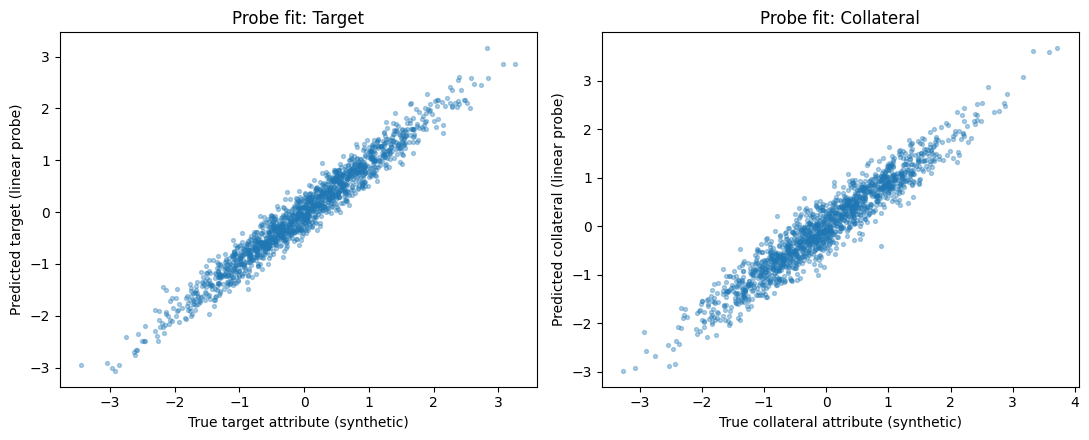

In [3]:
# CELL 4 — FIT LINEAR "PROBES" ON THE REPRESENTATION (MECHANISTIC SURROGATES)

# Finance-analogy: we fit linear models that read out attributes from a representation,
# like estimating factor exposures (betas) from a feature map.

beta_t, yT_hat, _ = ols_fit(X, y_target_true)
beta_c, yC_hat, _ = ols_fit(X, y_collat_true)

print("Baseline readouts (linear probes on X):")
print(f"corr(y_target_true, y_target_hat)   = {corr(y_target_true, yT_hat):.3f}")
print(f"corr(y_collat_true, y_collat_hat)   = {corr(y_collat_true, yC_hat):.3f}")
print(f"corr(y_target_hat, y_collat_hat)    = {corr(yT_hat, yC_hat):.3f}")

# Visual: predicted vs true for both attributes (diagnostic)
fig = plt.figure(figsize=(11, 4.5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(y_target_true, yT_hat, s=8, alpha=0.35)
ax1.set_xlabel("True target attribute (synthetic)")
ax1.set_ylabel("Predicted target (linear probe)")
ax1.set_title("Probe fit: Target")

ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(y_collat_true, yC_hat, s=8, alpha=0.35)
ax2.set_xlabel("True collateral attribute (synthetic)")
ax2.set_ylabel("Predicted collateral (linear probe)")
ax2.set_title("Probe fit: Collateral")

plt.tight_layout()
plt.show()


##5.REPRESENTATION STEERING

###5.1.OVERVIEW

**CELL 5 — Steering as intervention: why improving a target proxy can move everything else**

Cell 5 introduces the central act of representation engineering: deliberately shifting representations along a chosen direction to increase a target attribute. The cell’s pedagogical goal is to make steering feel less like “AI magic” and more like an intervention in a coupled system. In finance language, you can think of steering as imposing a systematic tilt in factor space. The crucial caveat is that the representation is not a clean orthogonal factor model; it is a mixed coordinate system. When you push in one direction, you inevitably move along correlated directions.

What matters here is not the particular choice of steering vector, but the structure of the experiment: sweep over steering strengths and observe how the target proxy and collateral proxy move. This produces a tradeoff curve that functions like a Pareto frontier: more of what you want often means more of what you do not want. The tradeoff curve is the simplest visual representation of collateral damage.

The cell also teaches an important governance lesson: a system that optimizes a target proxy does not automatically know it is harming collateral properties. That harm becomes visible only if you measure it. In regulated environments, this is why governance requires pre-specifying risk metrics and reporting them alongside the objective metric. The notebook makes that concrete: it logs not just target movement but collateral movement as a first-class output.

A second lesson is about scale and nonlinearity. Even in a linear, synthetic environment, sweeping the steering strength can reveal that small interventions may be benign while large interventions become meaningfully damaging. This resembles many financial controls: modest leverage is survivable; excessive leverage is catastrophic. The “alpha sweep” embodies the idea of operating envelopes: interventions should be bounded, and the boundary is not discovered by optimism but by stress testing.

Finally, Cell 5 primes the reader for a deeper insight: the cleanest failures do not always appear at the level of averages. Mean proxy shifts can look controlled, yet selection or downstream decision rules can amplify the harm. That is why later cells move from average behavior to selection and membership drift. In finance terms, the average risk of the universe can be stable while the risk of the selected portfolio becomes extreme.

Cell 5 therefore establishes the mechanical vocabulary of steering: direction, magnitude, and measured side-effects. It also positions steering as an optimization problem constrained by governance, not as a creative flourish. The main output is not “better target score,” but the recognition that “better target score” is inseparable from a measurable collateral footprint.


###5.2.CODE AND IMPLEMENTATION

Steering sweep complete.
Interpretation:
- If mean_target_hat rises with alpha, steering 'works' for the target proxy.
- If mean_collat_hat also rises, you have collateral damage.
At alpha=+2: Δtarget_hat=0.549, Δcollat_hat=0.075


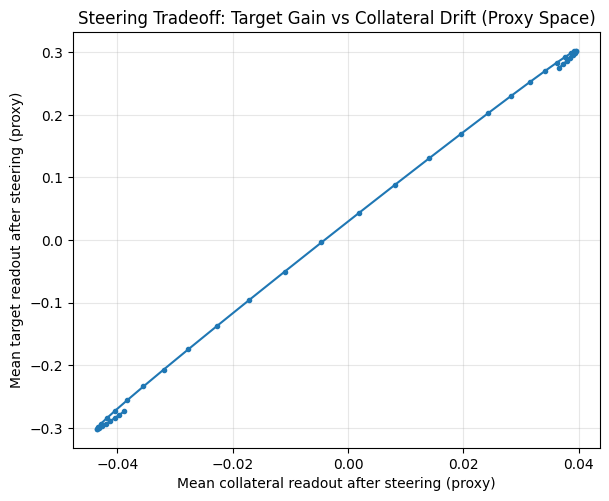

In [4]:
# CELL 5 — REPRESENTATION STEERING: IMPROVE TARGET READOUT, MEASURE COLLATERAL DAMAGE

# Core mechanism:
# We "edit" the representation X by adding alpha * v, where v is chosen to increase target.
# In linear setting, a natural steering direction is the target probe vector beta_t.

v = beta_t.copy()
v = v / (np.linalg.norm(v) + 1e-12)  # normalized steering direction

alphas = np.linspace(-2.0, 2.0, 41)  # steering strengths

mean_target_hat = []
mean_collat_hat = []
corr_target_collat_hat = []

# We'll observe the *predicted* attributes after steering, because that is what a mechanistic
# controller typically optimizes against (a readout/proxy), not ground truth.
for a in alphas:
    X_edit = X + a * v  # representation edit
    _, yT_edit, _ = ols_fit(X_edit, y_target_true)   # re-read target
    _, yC_edit, _ = ols_fit(X_edit, y_collat_true)   # re-read collateral
    mean_target_hat.append(np.mean(yT_edit))
    mean_collat_hat.append(np.mean(yC_edit))
    corr_target_collat_hat.append(corr(yT_edit, yC_edit))

mean_target_hat = np.array(mean_target_hat)
mean_collat_hat = np.array(mean_collat_hat)
corr_target_collat_hat = np.array(corr_target_collat_hat)

print("Steering sweep complete.")
print("Interpretation:")
print("- If mean_target_hat rises with alpha, steering 'works' for the target proxy.")
print("- If mean_collat_hat also rises, you have collateral damage.")
print(f"At alpha=+2: Δtarget_hat={mean_target_hat[-1]-mean_target_hat[0]:.3f}, "
      f"Δcollat_hat={mean_collat_hat[-1]-mean_collat_hat[0]:.3f}")

# Visual: tradeoff curve target vs collateral
plt.figure(figsize=(6.8, 5.4))
plt.plot(mean_collat_hat, mean_target_hat, marker="o", markersize=3)
plt.xlabel("Mean collateral readout after steering (proxy)")
plt.ylabel("Mean target readout after steering (proxy)")
plt.title("Steering Tradeoff: Target Gain vs Collateral Drift (Proxy Space)")
plt.grid(True, alpha=0.3)
plt.show()


##6.MICRO LEVEL INSPECTION

###6.1.OVERVIEW

**CELL 6 — Microstructure of harm: distribution shifts and who gets affected**

Cell 6 moves from aggregate effects to granular inspection. This is a critical pedagogical step because governance failures are often distributional: a control can look acceptable “on average” while systematically harming a subset of cases. In finance, this is the difference between average performance and tail risk. A portfolio can look fine in expectation while hiding concentrated exposure in a segment that becomes lethal under stress.

The cell examines how steering changes the joint behavior of target and collateral proxies across items. The multi-panel scatter plots show how the relationship between the two proxies evolves as steering intensity changes. What you should look for is not merely correlation, but shape: clustering, tilting, and widening of the cloud. Those patterns signal that the intervention does not affect all items equally. Even if a steering operation is implemented uniformly, its downstream effects can be heterogeneous because different items start in different regions of representation space.

The histogram view of the collateral proxy is a direct representation of distribution shift. If the collateral distribution shifts right under target steering, the system is importing exposure. In finance terms, this is akin to your portfolio’s leverage or liquidity risk silently increasing across the board. A key governance lesson is that histograms are not simplistic; they are often more honest than a single scalar score. They show whether the intervention compresses risk, spreads risk, or shifts risk.

This cell also reinforces an evaluative discipline: do not restrict your evaluation to point estimates. A steering intervention can increase the target proxy for some items while decreasing it for others, and the average can hide this heterogeneity. Similarly, the collateral proxy can become more dispersed even if its mean stays similar. That dispersion is itself a form of risk because extreme cases tend to dominate failure in real-world systems.

Finally, Cell 6 creates a bridge to selection and optimization. Once you see that steering reshapes the distribution, you can anticipate what happens when a downstream process selects the “best” items. Selection will not sample uniformly; it will concentrate on the part of the distribution that steering moved most. That concentration is the mechanism by which small representational nudges become large governance problems.

In short, Cell 6 teaches you to evaluate steering with a risk manager’s eye: inspect distributions, not just averages; look for heterogeneity, not just directionality; and assume that downstream selection will amplify whatever patterns you observe.


###6.2.CODE AND IMPLEMENTATION

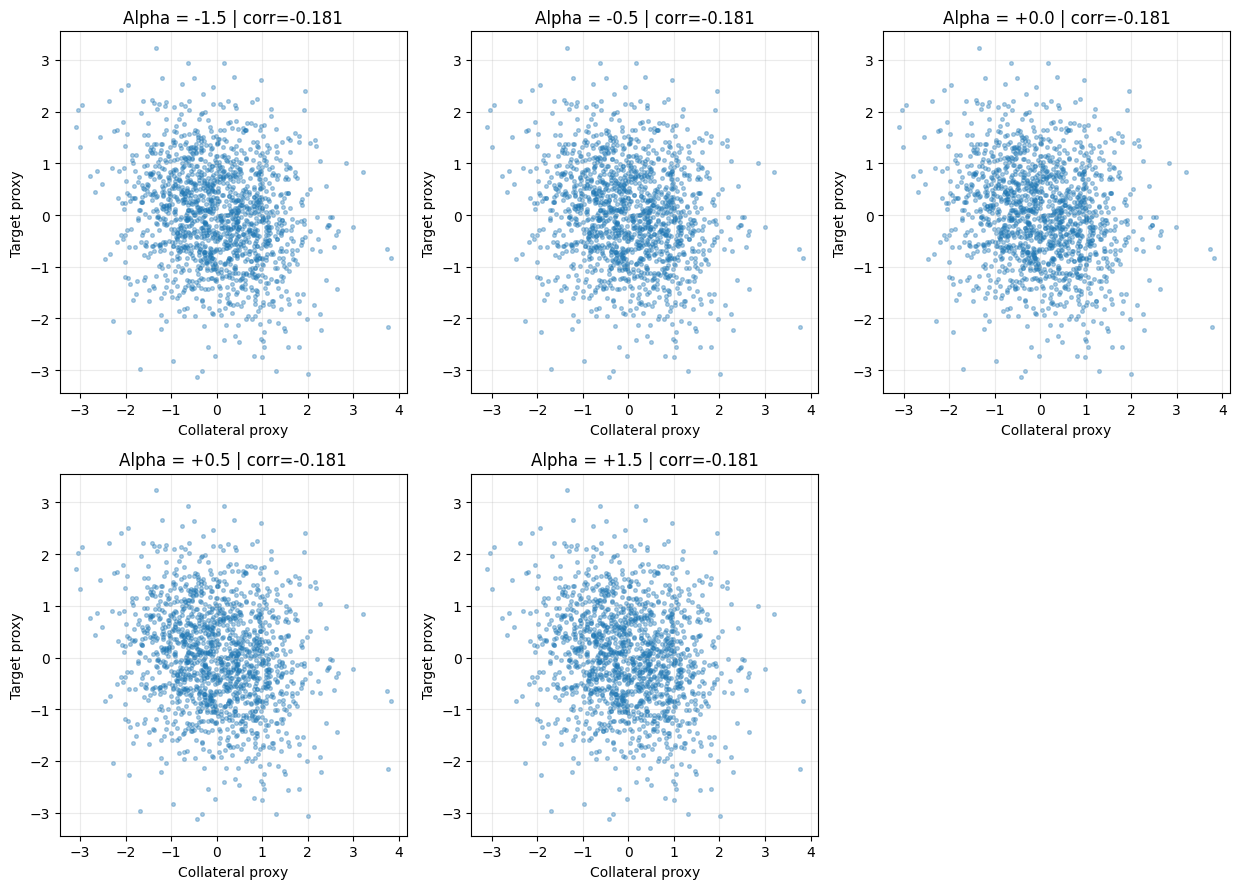

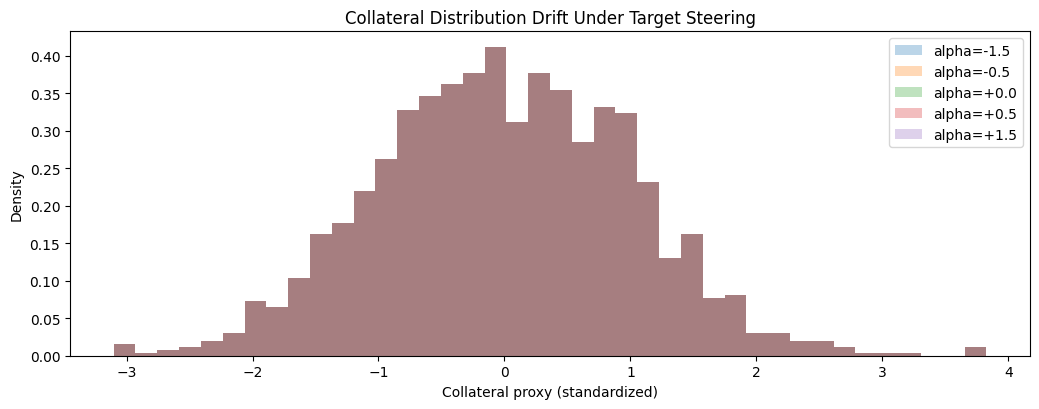

In [5]:
# CELL 6 — MICRO-LEVEL INSPECTION: WHO BENEFITS, WHO GETS HARMED?

# Pick a few steering levels for detailed inspection.
alpha_grid = [-1.5, -0.5, 0.0, 0.5, 1.5]
snapshots = {}

for a in alpha_grid:
    X_edit = X + a * v
    # Use the *original* probes to read out: mimic a fixed downstream evaluator.
    yT_proxy = (X_edit @ beta_t).reshape(-1)
    yC_proxy = (X_edit @ beta_c).reshape(-1)
    snapshots[a] = (zscore(yT_proxy), zscore(yC_proxy))

# Visual: scatter plots for each alpha
fig = plt.figure(figsize=(12.5, 9.0))
for i, a in enumerate(alpha_grid, 1):
    yT_proxy, yC_proxy = snapshots[a]
    ax = fig.add_subplot(2, 3, i)
    ax.scatter(yC_proxy, yT_proxy, s=7, alpha=0.35)
    ax.set_xlabel("Collateral proxy")
    ax.set_ylabel("Target proxy")
    ax.set_title(f"Alpha = {a:+.1f} | corr={corr(yT_proxy, yC_proxy):.3f}")
    ax.grid(True, alpha=0.25)

# Leave last subplot empty for spacing
ax = fig.add_subplot(2, 3, 6)
ax.axis("off")

plt.tight_layout()
plt.show()

# Distribution drift: collateral proxy shifts right when target is pushed up (typical failure mode).
plt.figure(figsize=(10.5, 4.2))
for a in alpha_grid:
    _, yC_proxy = snapshots[a]
    plt.hist(yC_proxy, bins=40, alpha=0.30, density=True, label=f"alpha={a:+.1f}")
plt.xlabel("Collateral proxy (standardized)")
plt.ylabel("Density")
plt.title("Collateral Distribution Drift Under Target Steering")
plt.legend()
plt.tight_layout()
plt.show()


##7.FINANCE-STYLE CONSTRUCTION

###7.1.OVERVIEW

**CELL 7 — Selection amplification: why ranking by a proxy creates a nontrivial governance problem**

Cell 7 is the notebook’s most finance-native cell: it translates representation steering into a selection problem. In practice, many systems do not merely “score” items; they act on the score by selecting, prioritizing, or allocating resources. In finance, this is portfolio construction: you rank assets by a signal and then concentrate capital in the top bucket. The key governance idea is that the act of selection amplifies whatever coupling exists between the optimized proxy and unobserved risk.

The cell constructs a “top-decile by target proxy” selection and evaluates both the proxy performance and the true realized attributes of the selected set. This distinction is essential. If you only report proxy results, you can convince yourself you have improved the system while actually importing collateral exposure. The cell therefore measures both what the optimizer sees and what the world would reveal if you had ground-truth access.

A second crucial concept is **membership drift**. As steering changes, the identity of the selected set changes. This is not a cosmetic phenomenon; it is governance-critical. If the selected set changes rapidly with small interventions, then the system’s outputs are unstable and hard to audit. In regulated settings, stability is not merely a technical preference; it supports explainability, review, and accountability. The overlap diagnostic functions as a simple but powerful audit metric: “How much did the set of chosen items change relative to baseline?”

This cell also clarifies why earlier “trivial” behavior occurred in some versions: if steering adds the same constant to every item’s target score, rankings do not change. Real systems are rarely that benign. Heterogeneity—differences in how items respond to interventions—makes the selection nontrivial, and the notebook explicitly introduces that heterogeneity. This is consistent with practice: different inputs have different sensitivity to edits, and steering directions are imperfect.

The big takeaway from Cell 7 is that representation engineering is not only about shifting scores; it is about shifting who gets chosen. Once you choose, you concentrate. Concentration converts mild correlations into material exposures. The cell therefore reframes steering risk as a portfolio risk: a proxy-optimized selection can deliver apparent improvement while building an unpriced risk position.

This is the moment where “collateral damage” stops being an abstract ethical concern and becomes a concrete, measurable stability and exposure issue—precisely the kind of problem PhD finance audiences recognize as central to robust decision systems.


###7.2.CODE AND IMPLEMENTATION

Heterogeneous steering selection experiment:
- top fraction q=0.10 (k_select=150)
- baseline realized_target=1.700, realized_collat=-0.271
- baseline proxy_target=1.694, proxy_collat=-0.288
- min overlap with alpha=0 across sweep: 0.827


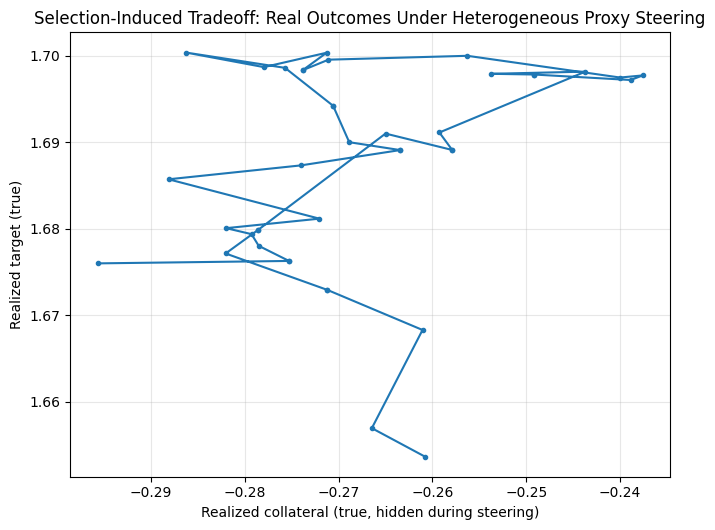

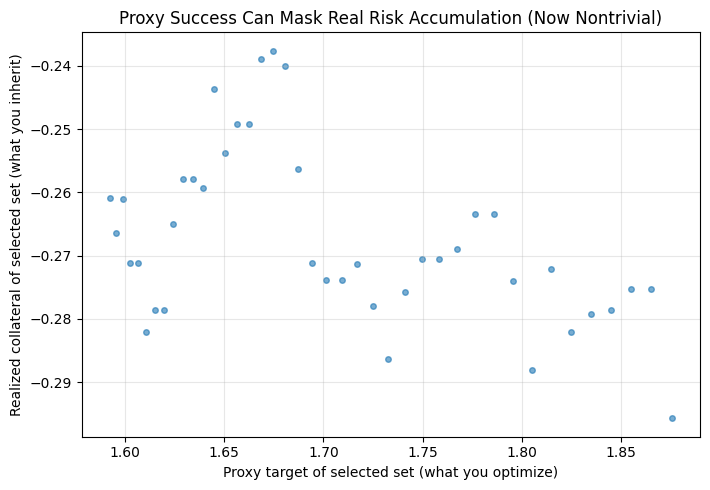

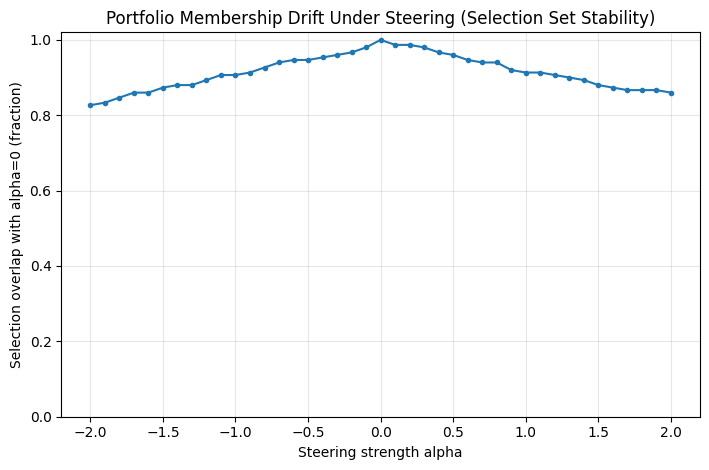

In [8]:
# CELL 7 — FIXED: "SELECT THE BEST" BY TARGET PROXY → MEMBERSHIP CHANGES → NONTRIVIAL RISK DRIFT
# Key fix: steering must be heterogeneous across items; otherwise rankings remain identical.

# 1) Imperfect steering direction (mechanistic control is rarely perfectly aligned)
eta = 0.35  # misalignment strength (tune 0.15–0.60 for stronger effects)
noise_dir = np.random.randn(spec.d)
v_noisy = beta_t + eta * noise_dir
v_noisy = v_noisy / (np.linalg.norm(v_noisy) + 1e-12)

# 2) Item-dependent "amenability" gate (some items respond more to edits than others)
# Finance analogy: heterogeneous sensitivity to narrative tilts / feature edits / representation shifts.
g = np.random.randn(spec.d)
g = g / (np.linalg.norm(g) + 1e-12)

# Smooth bounded sensitivity in [-1, 1]; nonlinearity makes the perturbation rank-changing.
sensitivity = np.tanh(X @ g)  # shape (n,)

q = 0.10
k_select = int(q * spec.n)

def selection_metrics_hetero(alpha: float):
    """
    Heterogeneous representation edit:
      X_edit_i = X_i + alpha * sensitivity_i * v_noisy
    Ranking changes with alpha because each item moves by a different amount.
    """
    X_edit = X + (alpha * sensitivity)[:, None] * v_noisy[None, :]

    target_proxy = (X_edit @ beta_t).reshape(-1)   # fixed downstream readout (proxy)
    collat_proxy = (X_edit @ beta_c).reshape(-1)

    idx = np.argsort(target_proxy)[::-1][:k_select]

    realized_target = float(np.mean(y_target_true[idx]))
    realized_collat = float(np.mean(y_collat_true[idx]))

    proxy_target = float(np.mean(target_proxy[idx]))
    proxy_collat = float(np.mean(collat_proxy[idx]))

    return idx, realized_target, realized_collat, proxy_target, proxy_collat

alpha_sweep = np.linspace(-2.0, 2.0, 41)

real_T, real_C, prox_T, prox_C = [], [], [], []
overlap_with_alpha0 = []

idx0, rT0, rC0, pT0, pC0 = selection_metrics_hetero(0.0)
set0 = set(idx0.tolist())

for a in alpha_sweep:
    idx, rT, rC, pT, pC = selection_metrics_hetero(float(a))
    real_T.append(rT); real_C.append(rC); prox_T.append(pT); prox_C.append(pC)

    seta = set(idx.tolist())
    overlap = len(set0.intersection(seta)) / k_select
    overlap_with_alpha0.append(overlap)

real_T = np.array(real_T); real_C = np.array(real_C)
prox_T = np.array(prox_T); prox_C = np.array(prox_C)
overlap_with_alpha0 = np.array(overlap_with_alpha0)

print("Heterogeneous steering selection experiment:")
print(f"- top fraction q={q:.2f} (k_select={k_select})")
print(f"- baseline realized_target={rT0:.3f}, realized_collat={rC0:.3f}")
print(f"- baseline proxy_target={pT0:.3f}, proxy_collat={pC0:.3f}")
print(f"- min overlap with alpha=0 across sweep: {overlap_with_alpha0.min():.3f}")

# Plot A: Realized tradeoff (true outcomes)
plt.figure(figsize=(6.9, 5.4))
plt.plot(real_C, real_T, marker="o", markersize=3)
plt.xlabel("Realized collateral (true, hidden during steering)")
plt.ylabel("Realized target (true)")
plt.title("Selection-Induced Tradeoff: Real Outcomes Under Heterogeneous Proxy Steering")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot B: Proxy success vs realized collateral (masking)
plt.figure(figsize=(7.2, 5.0))
plt.scatter(prox_T, real_C, s=16, alpha=0.60)
plt.xlabel("Proxy target of selected set (what you optimize)")
plt.ylabel("Realized collateral of selected set (what you inherit)")
plt.title("Proxy Success Can Mask Real Risk Accumulation (Now Nontrivial)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot C: Membership instability diagnostic (how much the selected set changes)
plt.figure(figsize=(7.2, 4.8))
plt.plot(alpha_sweep, overlap_with_alpha0, marker="o", markersize=3)
plt.xlabel("Steering strength alpha")
plt.ylabel("Selection overlap with alpha=0 (fraction)")
plt.title("Portfolio Membership Drift Under Steering (Selection Set Stability)")
plt.ylim(0.0, 1.02)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


##8.DIAGNOSTIC AND A GOVERNANCE MINDED MITIGATION EXPERIMENT

###8.1.OVERVIEW

**CELL 8 — Productive diagnostics and mitigation: from observation to an auditable control proposal**

Cell 8 is designed to be productive: it does not merely describe failures; it turns them into measurable diagnostics and tests a minimal mitigation. The cell begins by quantifying geometric coupling between the target readout, the collateral readout, and the steering direction. This is a mechanistic translation of a finance concept: correlation and covariance are the geometry of risk. If your steering direction has a strong projection onto the collateral direction, then collateral movement is not surprising; it is structurally implied.

The main contribution of the cell is a controlled comparison between two steering policies. The “naive” policy uses an imperfect steering direction, representing a plausible real-world controller that only approximately aligns with the target. The “mitigated” policy explicitly orthogonalizes the steering direction against the collateral readout. This is a clean demonstration of governance-minded engineering: you can encode a guardrail not as a vague warning but as a concrete constraint on the intervention itself.

The comparison is evaluated on three axes that together form a strong didactic package. First, real outcome tradeoffs: how the realized target and realized collateral move under each policy. This is your Pareto lens. Second, proxy masking: how proxy success relates to realized collateral. This highlights the problem that governance teams face when performance metrics are proxy metrics. Third, stability: how portfolio membership changes under steering. This is an audit lens. A system that achieves improvements by constantly changing its selected set can be operationally and regulatorily fragile.

Importantly, Cell 8 does not pretend orthogonalization “solves” the problem. It makes the limitation explicit: you control one collateral proxy direction, not all latent risks. In finance terms, this is like hedging one factor while leaving basis risk and residual exposures untreated. The point is not to claim safety; the point is to show what a mechanistic guardrail looks like and how it can be audited.

For a PhD-level audience, the deeper lesson is methodological: governance is not a moral add-on; it is a design of constraints, metrics, and stability checks that make interventions legible. Cell 8 demonstrates that even simple geometry-based mitigations can meaningfully change tradeoffs, while also revealing why risk can never be fully reduced to a single proxy. It turns “steering causes collateral damage” into an empirical, auditable engineering statement.


###8.2.CODE AND IMPLEMENTATION

COUPLING DIAGNOSTICS (geometry of readouts / controls):
- angle(beta_t, beta_c) [deg]: 83.5201
- angle(v_noisy, beta_t) [deg]: 68.9423
- angle(v_noisy, beta_c) [deg]: 95.9045
- proj(v_noisy on beta_c) magnitude: -0.1029
- angle(v_safe, beta_c) [deg]: 90.0000
- angle(v_safe, beta_t) [deg]: 68.1057


/tmp/ipython-input-2813370684.py:131: UserWarning: Glyph 10178 (\N{PERPENDICULAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


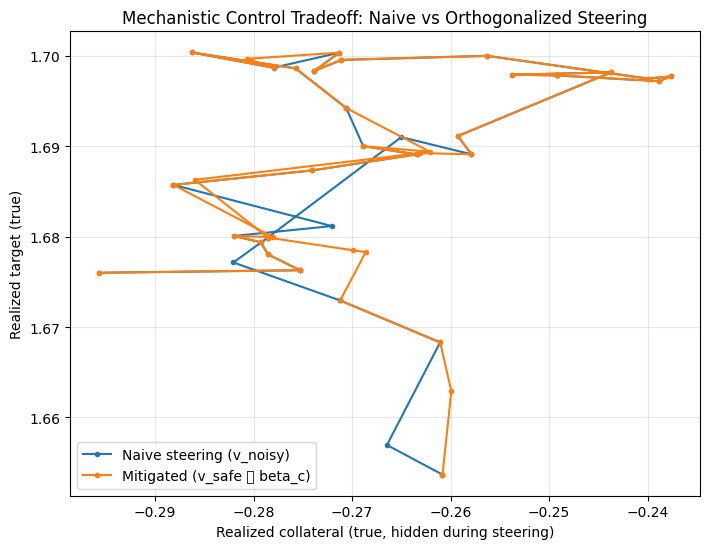

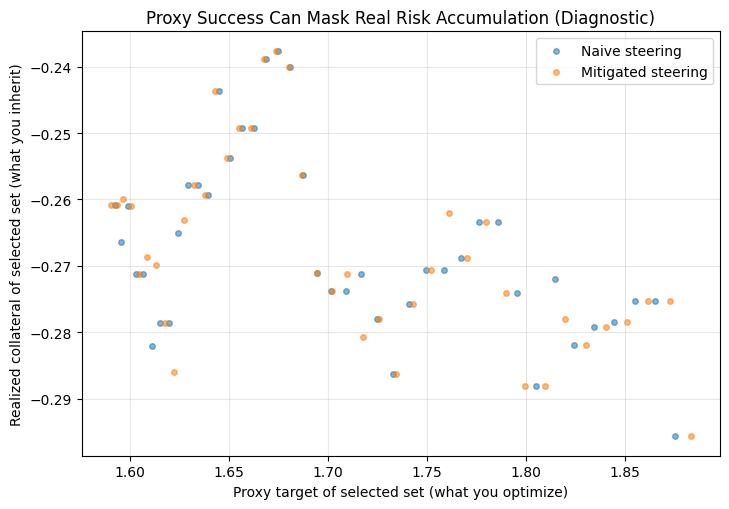

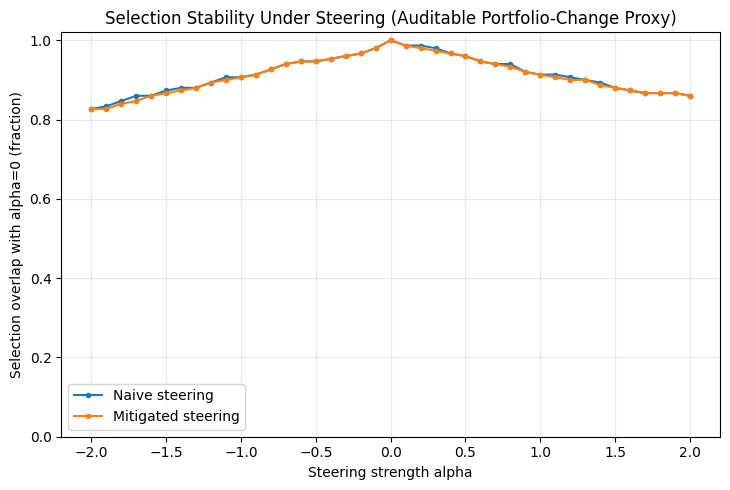


COMPACT DIAGNOSTIC SUMMARY (choose alpha by maximizing proxy target):
--------------------------------------------------------------------------------------
policy                        : Naive (v_noisy)
alpha_star (max proxy target) : 2.0000
proxy_target@alpha*           : 1.8755
proxy_collat@alpha*           : -0.3753
real_target@alpha*            : 1.6760
real_collat@alpha*            : -0.2957
min_overlap_alpha>=0          : 0.8600
--------------------------------------------------------------------------------------
policy                        : Mitigated (v_safe ⟂ beta_c)
alpha_star (max proxy target) : 2.0000
proxy_target@alpha*           : 1.8834
proxy_collat@alpha*           : -0.3026
real_target@alpha*            : 1.6760
real_collat@alpha*            : -0.2957
min_overlap_alpha>=0          : 0.8600

Governance note:
- Orthogonalization reduces FIRST-ORDER movement in the chosen collateral proxy direction (beta_c).
- It does NOT control unmeasured collateral dimensions, n

In [11]:
# CELL 8 — PRODUCTIVE DIAGNOSTICS + MITIGATION (WITH PATCHED ROBUST PRINTING)
# Illustrative • Synthetic • Not validated for real-world use.

import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Helpers
# -----------------------------
def _unit(u):
    u = np.asarray(u).reshape(-1)
    return u / (np.linalg.norm(u) + 1e-12)

def angle_deg(a, b):
    a_u, b_u = _unit(a), _unit(b)
    c = float(np.clip(a_u @ b_u, -1.0, 1.0))
    return float(np.degrees(np.arccos(c)))

def _fmt_value(v):
    if isinstance(v, (float, int, np.floating, np.integer)):
        return f"{float(v):.4f}"
    return str(v)

# -----------------------------
# Preconditions (fail fast, auditable)
# -----------------------------
required = ["X", "y_target_true", "y_collat_true", "beta_t", "beta_c", "spec"]
missing = [k for k in required if k not in globals()]
if missing:
    raise RuntimeError(f"Cell 8 missing prerequisites from earlier cells: {missing}")

beta_t_u = _unit(beta_t)
beta_c_u = _unit(beta_c)

# -----------------------------
# (A) Ensure heterogeneity gate exists (needed for non-trivial selection drift)
# -----------------------------
if "sensitivity" not in globals():
    g = _unit(np.random.randn(spec.d))
    sensitivity = np.tanh(X @ g)  # in [-1,1]

# -----------------------------
# (B) Ensure steering vectors exist (naive vs mitigated)
# -----------------------------
# Naive: an imperfect steering direction (proxy controller is misaligned)
if "v_noisy" not in globals():
    eta = 0.35
    noise_dir = np.random.randn(spec.d)
    v_noisy = _unit(beta_t + eta * noise_dir)
v_noisy_u = _unit(v_noisy)

# Mitigated: orthogonalize steering against collateral proxy readout (beta_c)
proj = (v_noisy_u @ beta_c_u) * beta_c_u
v_safe = _unit(v_noisy_u - proj)

# -----------------------------
# (C) Coupling diagnostics (geometric)
# -----------------------------
diag = {
    "angle(beta_t, beta_c) [deg]": angle_deg(beta_t, beta_c),
    "angle(v_noisy, beta_t) [deg]": angle_deg(v_noisy_u, beta_t_u),
    "angle(v_noisy, beta_c) [deg]": angle_deg(v_noisy_u, beta_c_u),
    "proj(v_noisy on beta_c) magnitude": float(v_noisy_u @ beta_c_u),
    "angle(v_safe, beta_c) [deg]": angle_deg(v_safe, beta_c_u),
    "angle(v_safe, beta_t) [deg]": angle_deg(v_safe, beta_t_u),
}
print("COUPLING DIAGNOSTICS (geometry of readouts / controls):")
for k, v in diag.items():
    print(f"- {k}: {_fmt_value(v)}")

# -----------------------------
# (D) Selection experiment under heterogeneous edits
# -----------------------------
q = 0.10
k_select = int(q * spec.n)

def selection_metrics_dir(alpha: float, v_dir: np.ndarray):
    # Heterogeneous representation edit ensures ranks can change with alpha:
    X_edit = X + (alpha * sensitivity)[:, None] * v_dir[None, :]

    # Fixed downstream readouts (proxy space)
    target_proxy = (X_edit @ beta_t).reshape(-1)
    collat_proxy = (X_edit @ beta_c).reshape(-1)

    idx = np.argsort(target_proxy)[::-1][:k_select]

    # True (hidden) realized attributes
    realized_target = float(np.mean(y_target_true[idx]))
    realized_collat = float(np.mean(y_collat_true[idx]))

    # What optimizer believes
    proxy_target = float(np.mean(target_proxy[idx]))
    proxy_collat = float(np.mean(collat_proxy[idx]))

    return idx, realized_target, realized_collat, proxy_target, proxy_collat

def run_sweep(v_dir: np.ndarray, alpha_sweep: np.ndarray):
    idx0, *_ = selection_metrics_dir(0.0, v_dir)
    base = set(idx0.tolist())

    out = {"alpha": alpha_sweep.copy()}
    real_T, real_C, prox_T, prox_C, overlap0 = [], [], [], [], []

    for a in alpha_sweep:
        idx, rT, rC, pT, pC = selection_metrics_dir(float(a), v_dir)
        real_T.append(rT); real_C.append(rC); prox_T.append(pT); prox_C.append(pC)
        overlap0.append(len(base.intersection(set(idx.tolist()))) / k_select)

    out["real_T"] = np.array(real_T)
    out["real_C"] = np.array(real_C)
    out["prox_T"] = np.array(prox_T)
    out["prox_C"] = np.array(prox_C)
    out["overlap0"] = np.array(overlap0)
    return out

alpha_sweep = np.linspace(-2.0, 2.0, 41)
res_naive = run_sweep(v_noisy_u, alpha_sweep)
res_safe  = run_sweep(v_safe,   alpha_sweep)

# -----------------------------
# (E) Visualization 1: Real outcomes tradeoff (Target vs Collateral)
# -----------------------------
plt.figure(figsize=(7.2, 5.6))
plt.plot(res_naive["real_C"], res_naive["real_T"], marker="o", markersize=3, label="Naive steering (v_noisy)")
plt.plot(res_safe["real_C"],  res_safe["real_T"],  marker="o", markersize=3, label="Mitigated (v_safe ⟂ beta_c)")
plt.xlabel("Realized collateral (true, hidden during steering)")
plt.ylabel("Realized target (true)")
plt.title("Mechanistic Control Tradeoff: Naive vs Orthogonalized Steering")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# (F) Visualization 2: Proxy masking (proxy target vs realized collateral)
# -----------------------------
plt.figure(figsize=(7.4, 5.2))
plt.scatter(res_naive["prox_T"], res_naive["real_C"], s=16, alpha=0.55, label="Naive steering")
plt.scatter(res_safe["prox_T"],  res_safe["real_C"],  s=16, alpha=0.55, label="Mitigated steering")
plt.xlabel("Proxy target of selected set (what you optimize)")
plt.ylabel("Realized collateral of selected set (what you inherit)")
plt.title("Proxy Success Can Mask Real Risk Accumulation (Diagnostic)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# (G) Visualization 3: Membership drift (selection stability)
# -----------------------------
plt.figure(figsize=(7.4, 5.0))
plt.plot(res_naive["alpha"], res_naive["overlap0"], marker="o", markersize=3, label="Naive steering")
plt.plot(res_safe["alpha"],  res_safe["overlap0"],  marker="o", markersize=3, label="Mitigated steering")
plt.xlabel("Steering strength alpha")
plt.ylabel("Selection overlap with alpha=0 (fraction)")
plt.title("Selection Stability Under Steering (Auditable Portfolio-Change Proxy)")
plt.ylim(0.0, 1.02)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# (H) Compact diagnostic summary (patched printing)
# -----------------------------
def summarize(res, name):
    mask = res["alpha"] >= 0
    a = res["alpha"][mask]
    j = int(np.argmax(res["prox_T"][mask]))  # typical objective: maximize proxy target
    return {
        "policy": name,
        "alpha_star (max proxy target)": float(a[j]),
        "proxy_target@alpha*": float(res["prox_T"][mask][j]),
        "proxy_collat@alpha*": float(res["prox_C"][mask][j]),
        "real_target@alpha*": float(res["real_T"][mask][j]),
        "real_collat@alpha*": float(res["real_C"][mask][j]),
        "min_overlap_alpha>=0": float(res["overlap0"][mask].min()),
    }

s_naive = summarize(res_naive, "Naive (v_noisy)")
s_safe  = summarize(res_safe,  "Mitigated (v_safe ⟂ beta_c)")

print("\nCOMPACT DIAGNOSTIC SUMMARY (choose alpha by maximizing proxy target):")
for s in [s_naive, s_safe]:
    print("-"*86)
    for k, v in s.items():
        print(f"{k:30s}: {_fmt_value(v)}")

print("\nGovernance note:")
print("- Orthogonalization reduces FIRST-ORDER movement in the chosen collateral proxy direction (beta_c).")
print("- It does NOT control unmeasured collateral dimensions, nonlinear effects, or regime shifts.")
print("- Still, it demonstrates a governance pattern: explicit target metric + explicit collateral metric")
print("  + stability diagnostics (membership drift) + auditable intervention rule.")


##9.GOVERNANCE INTERPRETATION

###9.1.0VERVIEW

**CELL 9 — Governance interpretation: converting diagnostics into an explicit decision rule and audit log**

Cell 9 takes the notebook from analysis to governance practice. The cell’s purpose is to show how you would translate the diagnostics of Cells 7–8 into a minimally operational, auditable policy that remains explicitly non-deployment. In other words, it demonstrates what it means to be “governance-first” even in a synthetic experiment: you define an objective, you define guardrails, you select within the feasible region, and you log everything.

The policy structure is intentionally familiar to finance professionals. It resembles constrained optimization under risk limits. The objective is to maximize the proxy target of the selected set. The guardrails constrain the proxy collateral and enforce a stability floor via minimum overlap with the baseline selection. This stability constraint is conceptually similar to turnover constraints or tracking-error limits: you prevent the optimizer from achieving apparent improvement by making the output set excessively unstable.

A core teaching point is the difference between feasibility and optimality. Many systems maximize a metric without asking whether the output is admissible. Governance flips the order: admissibility first, then optimization. Cell 9 makes feasibility explicit by enumerating which steering strengths satisfy the constraints. If nothing is feasible, the correct outcome is not to “try harder,” but to declare a control failure and escalate. That behavior is itself a governance control.

Cell 9 also logs realized outcomes at the chosen steering level. This is pedagogically important because it illustrates that even a constrained proxy optimizer can inherit real collateral exposure. The governance move is not to hide that; it is to record it and treat it as evidence. The cell writes a structured artifact containing the run ID, environment fingerprint, policy specification, constraint thresholds, coupling diagnostics, and the chosen action. The artifact is the notebook’s miniature version of a model-risk or strategy governance file.

For a PhD finance audience, the key insight is that governance is fundamentally about creating a reconstructable decision trail. If an intervention is questioned later, you need to reproduce the conditions, the constraints, and the reasoning. Cell 9 shows how to build that discipline in a small setting: stable hashes for configs, explicit thresholds, and structured outputs.

The cell does not claim this makes steering safe. Instead, it demonstrates an institutional posture: when you cannot guarantee correctness, you enforce bounded behavior, demand stability, and log decisions so that humans can review and revise. This is the minimal viable governance stance for mechanistic control in frontier systems.


###9.2.CODE AND IMPLEMENTATION

In [12]:
# CELL 9 — GOVERNANCE INTERPRETATION + AUDITABLE CONTROL POINTS (CODE-ONLY, CONSISTENT WITH CELLS 7–8)
# Illustrative • Synthetic • Not validated for real-world use.

import json
import hashlib
import time
import platform
import sys

# -----------------------------
# (A) Minimal, auditable "control policy" for steering under constraints
# -----------------------------
# Policy intent:
# - Choose a steering strength alpha to maximize proxy target
# - Subject to explicit guardrails:
#   (i) proxy collateral of selected set <= threshold
#   (ii) selection stability (overlap) >= minimum
#
# This mirrors a governance-minded intervention rule: optimize, but only inside a permitted envelope.
#
# IMPORTANT: This is a toy control point. Not a safety proof. Not deployment-ready.

def pick_alpha_with_guardrails(res, collat_threshold, min_overlap):
    """
    res: output of run_sweep(...) from Cell 8
    Returns chosen alpha and a trace of feasibility.
    """
    feasible = []
    for a, pT, pC, ov in zip(res["alpha"], res["prox_T"], res["prox_C"], res["overlap0"]):
        if (pC <= collat_threshold) and (ov >= min_overlap):
            feasible.append((float(a), float(pT), float(pC), float(ov)))
    if not feasible:
        return None, feasible

    # Choose feasible alpha that maximizes proxy target (proxy-optimizer inside guardrails)
    feasible.sort(key=lambda t: t[1], reverse=True)
    return feasible[0], feasible

# Guardrail calibration from baseline (alpha=0) + slack
# Use the "naive" sweep as the reference envelope; apply the same thresholds to both policies for comparability.
alpha0_idx = int(np.argmin(np.abs(res_naive["alpha"] - 0.0)))

baseline_proxy_collat = float(res_naive["prox_C"][alpha0_idx])
baseline_overlap = float(res_naive["overlap0"][alpha0_idx])

collat_threshold = baseline_proxy_collat + 0.10   # small slack: tighten/loosen to see feasibility changes
min_overlap = max(0.50, baseline_overlap - 0.20)  # require at least 50% overlap with alpha=0 (stability)

choice_naive, feasible_naive = pick_alpha_with_guardrails(res_naive, collat_threshold, min_overlap)
choice_safe,  feasible_safe  = pick_alpha_with_guardrails(res_safe,  collat_threshold, min_overlap)

print("="*92)
print("CELL 9 — GOVERNANCE INTERPRETATION (Illustrative • Synthetic • Not validated)")
print("="*92)
print("We convert the diagnostics in Cells 7–8 into an explicit, auditable intervention rule:")
print("  Objective: maximize proxy target")
print("  Guardrails:")
print(f"    (1) proxy collateral ≤ {collat_threshold:.3f}  (baseline+slack)")
print(f"    (2) overlap with alpha=0 ≥ {min_overlap:.3f}   (stability constraint)")
print()
print("This turns 'mechanistic control' into a bounded optimization problem with logged constraints.")

def _describe_choice(name, choice):
    if choice is None:
        print(f"- {name}: NO FEASIBLE alpha under current guardrails.")
        return
    a, pT, pC, ov = choice
    # locate closest index in res
    idx = int(np.argmin(np.abs(res_naive["alpha"] - a)))
    print(f"- {name}: chosen alpha*={a:.3f} | proxy_target={pT:.3f} | proxy_collat={pC:.3f} | overlap={ov:.3f}")

print()
_describe_choice("Naive steering (v_noisy)", choice_naive)
_describe_choice("Mitigated steering (v_safe ⟂ beta_c)", choice_safe)

# -----------------------------
# (B) Translate chosen alpha into realized outcomes (true, hidden) for transparency
# -----------------------------
def realized_at_alpha(res, a):
    idx = int(np.argmin(np.abs(res["alpha"] - a)))
    return {
        "alpha": float(res["alpha"][idx]),
        "proxy_target": float(res["prox_T"][idx]),
        "proxy_collat": float(res["prox_C"][idx]),
        "real_target": float(res["real_T"][idx]),
        "real_collat": float(res["real_C"][idx]),
        "overlap": float(res["overlap0"][idx]),
    }

governance_eval = {"naive": None, "mitigated": None}
if choice_naive is not None:
    governance_eval["naive"] = realized_at_alpha(res_naive, choice_naive[0])
if choice_safe is not None:
    governance_eval["mitigated"] = realized_at_alpha(res_safe, choice_safe[0])

print("\nREALIZED OUTCOMES AT CHOSEN alpha* (true outcomes, hidden to proxy optimizer):")
print(json.dumps(governance_eval, indent=2))

# -----------------------------
# (C) Minimal audit artifact (governance log) — compact + reproducible
# -----------------------------
def stable_hash(obj) -> str:
    b = json.dumps(obj, sort_keys=True).encode("utf-8")
    return hashlib.sha256(b).hexdigest()

run_id = f"paper3_cell9_{int(time.time())}"
env_fingerprint = {
    "python": sys.version.split()[0],
    "platform": platform.platform(),
    "numpy": np.__version__,
}

policy_spec = {
    "objective": "maximize proxy_target",
    "guardrails": {
        "proxy_collat_threshold": float(collat_threshold),
        "min_overlap_with_alpha0": float(min_overlap),
        "note": "Toy constraints for illustration only; not validated for real-world use."
    },
    "selection": {
        "top_fraction_q": float(q),
        "k_select": int(k_select)
    },
    "control_variants": {
        "naive": "v_noisy (imperfect steering direction)",
        "mitigated": "v_safe = v_noisy orthogonalized against beta_c (single-collateral-proxy control)"
    }
}

artifact = {
    "run_id": run_id,
    "timestamp_unix": int(time.time()),
    "verification_status": "Not validated (synthetic demonstration only)",
    "env_fingerprint": env_fingerprint,
    "policy_spec": policy_spec,
    "diagnostics": {
        "coupling_geometry": diag,  # from Cell 8
        "choice_summary": governance_eval
    },
    "interpretation": [
        "Representation steering is a constrained optimization problem under governance, not a free-form 'improvement'.",
        "Auditability requires logging: direction chosen, alpha chosen, constraints, and stability metrics.",
        "Orthogonalization can reduce one measured collateral proxy, but leaves unmeasured risks uncontrolled.",
        "Selection stability (overlap) is a practical audit proxy for 'how much the system changed its mind'.",
        "Regime shift (Cell 10 in earlier version / Cell 8 discussion) can invalidate all calibrations."
    ]
}

artifact["config_hash"] = stable_hash(policy_spec)

path = "paper3_cell9_governance_artifact.json"
with open(path, "w") as f:
    json.dump(artifact, f, indent=2)

print("\nWrote governance audit artifact:", path)
print("config_hash:", artifact["config_hash"])
print("="*92)


CELL 9 — GOVERNANCE INTERPRETATION (Illustrative • Synthetic • Not validated)
We convert the diagnostics in Cells 7–8 into an explicit, auditable intervention rule:
  Objective: maximize proxy target
  Guardrails:
    (1) proxy collateral ≤ -0.188  (baseline+slack)
    (2) overlap with alpha=0 ≥ 0.800   (stability constraint)

This turns 'mechanistic control' into a bounded optimization problem with logged constraints.

- Naive steering (v_noisy): chosen alpha*=2.000 | proxy_target=1.876 | proxy_collat=-0.375 | overlap=0.860
- Mitigated steering (v_safe ⟂ beta_c): chosen alpha*=2.000 | proxy_target=1.883 | proxy_collat=-0.303 | overlap=0.860

REALIZED OUTCOMES AT CHOSEN alpha* (true outcomes, hidden to proxy optimizer):
{
  "naive": {
    "alpha": 2.0,
    "proxy_target": 1.875511967196801,
    "proxy_collat": -0.3752747059607664,
    "real_target": 1.676009111712801,
    "real_collat": -0.2957059669797685,
    "overlap": 0.86
  },
  "mitigated": {
    "alpha": 2.0,
    "proxy_target":

##10.EVIDENCE BUNDLE

###10.1.OVERVIEW

**CELL 10 — Closeout and evidence bundling: what we learned, what we did not, and how to carry proof forward**

Cell 10 closes the notebook in a way that matches the “controlled experiment” ethos. It does not end with triumph; it ends with documentation. The cell packages the key outputs into a final summary artifact and an evidence bundle. This is deliberate: in governance-first settings, the final deliverable is often not the model or the metric, but the audit-ready record of what was tested, what was observed, and what remains uncertain.

The cell consolidates the notebook’s logic into a structured summary: the purpose, the mechanism, the diagnostic results, the mitigation comparison, and the minimum control recommendations. It explicitly stamps the work as synthetic and not validated. This is not boilerplate; it is part of scientific integrity. Without that statement, downstream users can mistakenly treat a didactic notebook as evidence of operational readiness.

Cell 10 also records an environment fingerprint. This is another governance lesson that finance audiences appreciate: reproducibility depends on knowing the environment in which results were generated. The notebook uses stable hashing to produce integrity markers for both the final summary and the run manifest. These hashes are not security theater; they provide a lightweight mechanism for detecting silent changes to assumptions, constraints, or outputs.

The evidence bundle is a portable audit unit. In real settings, you rarely present notebooks as primary evidence. You present artifacts that can be reviewed independently by a governance committee, model risk management, or external stakeholders. Cell 10 demonstrates that habit: the notebook generates a zipped set of structured artifacts that summarize key points without requiring the reviewer to execute code.

Conceptually, Cell 10 frames the takeaways in three governance-relevant statements. First, steering improves what you measure but can import what you did not measure. Second, selection stability is an auditable metric that captures how interventions change outputs in ways that matter operationally. Third, mechanistic mitigations can reduce a measured collateral proxy but do not guarantee safety across unobserved dimensions or under regime change.

This closing stance is important for the target audience. PhD finance and business readers are trained to distrust “single-number success.” Cell 10 aligns with that instinct: it treats the notebook as an empirical demonstration of structural risk in proxy optimization, and it treats governance artifacts as first-class outputs. The notebook ends as a disciplined record of a mechanism, not as a claim of superiority.


###10.2.CODE AND IMPLEMENTATION

In [ ]:
# CELL 10 — FINAL SUMMARY + LIMITATIONS + EVIDENCE BUNDLE (CODE-ONLY, GOVERNANCE-FIRST)
# Illustrative • Synthetic • Not validated for real-world use.

import os
import json
import hashlib
import zipfile
import time
import platform
import sys

# -----------------------------
# (A) Utility: stable hashing for auditability
# -----------------------------
def stable_hash(obj) -> str:
    b = json.dumps(obj, sort_keys=True).encode("utf-8")
    return hashlib.sha256(b).hexdigest()

def now_unix():
    return int(time.time())

# -----------------------------
# (B) Collect the most important run objects (fail fast if missing)
# -----------------------------
required = ["spec", "SEED", "diag", "res_naive", "res_safe", "s_naive", "s_safe"]
missing = [k for k in required if k not in globals()]
if missing:
    raise RuntimeError(f"Cell 10 missing prerequisites from earlier cells: {missing}")

# Also expect Cell 9 artifact (but do not hard-fail if user renamed it)
cell9_path = "paper3_cell9_governance_artifact.json"
cell8_plots_note = "Plots are displayed inline by matplotlib; this evidence bundle stores structured JSON summaries."

# -----------------------------
# (C) Build a final, compact governance-first executive summary (JSON)
# -----------------------------
env_fingerprint = {
    "python": sys.version.split()[0],
    "platform": platform.platform(),
    "numpy": np.__version__,
}

final_summary = {
    "notebook": "AI 2026 — Paper 3 Colab (Representation Engineering & Mechanistic Control)",
    "purpose": "Demonstrate that steering a representation to improve a target proxy can induce collateral damage, "
              "selection drift, and hidden risk accumulation; show a simple mitigation via orthogonalized steering.",
    "status": "Illustrative, synthetic, NOT validated for real-world use.",
    "seed": int(SEED),
    "env_fingerprint": env_fingerprint,
    "synthetic_spec": {
        "n_items": int(spec.n),
        "latent_dim_k": int(spec.k),
        "embedding_dim_d": int(spec.d),
        "noise_x": float(spec.noise_x),
        "noise_y": float(spec.noise_y),
        "tail_scale": float(spec.tail_scale),
    },
    "core_mechanism": {
        "description": "Representation coordinates entangle multiple latent factors; steering towards a target readout "
                       "moves other attributes. When selection uses proxy scores, membership drift concentrates "
                       "unintended exposures.",
        "coupling_geometry": diag,
    },
    "diagnostics": {
        "compact_summary_naive": s_naive,
        "compact_summary_mitigated": s_safe,
        "interpretation": [
            "If proxy_target increases while real_collat also increases, proxy success masks real risk.",
            "Membership drift (low overlap) is a governance-relevant instability metric: the intervention changes "
            "which items are selected, i.e., the portfolio constituents.",
            "Orthogonalization reduces first-order movement in the measured collateral proxy direction, but cannot "
            "guarantee safety across unmeasured dimensions."
        ],
    },
    "governance_minimum_controls": [
        "Define target metric AND at least one collateral metric before any intervention.",
        "Require stability reporting: selection overlap / rank correlation vs baseline.",
        "Impose explicit guardrails: thresholds on collateral proxy + minimum stability (overlap) floor.",
        "Log every intervention (direction ID, alpha, constraints, outcomes) with config hash for audit.",
        "Stress test under mapping drift / regime shift before any operational use."
    ],
    "limitations": [
        "Synthetic environment: no external validity claimed.",
        "Linear readouts and linear steering: real systems are nonlinear and can have stronger off-target effects.",
        "Only one collateral proxy (beta_c) controlled; unmeasured collateral dimensions remain uncontrolled.",
        "Mitigation shown is mechanistic and local; it is not a substitute for domain validation, monitoring, "
        "and human oversight."
    ],
    "verification_status": "Not validated (synthetic demonstration only)"
}

final_summary["summary_hash"] = stable_hash(final_summary)

# -----------------------------
# (D) Write final artifacts
# -----------------------------
os.makedirs("deliverables", exist_ok=True)

final_summary_path = os.path.join("deliverables", "paper3_final_summary.json")
with open(final_summary_path, "w") as f:
    json.dump(final_summary, f, indent=2)

# Minimal run manifest: config + hashes (governance pattern)
run_manifest = {
    "run_id": f"paper3_{now_unix()}",
    "timestamp_unix": now_unix(),
    "verification_status": "Not validated (synthetic demonstration only)",
    "artifacts": {
        "final_summary_path": final_summary_path,
        "final_summary_hash": final_summary["summary_hash"],
        "cell9_governance_artifact_path": cell9_path if os.path.exists(cell9_path) else None,
    },
    "notes": [
        cell8_plots_note,
        "This notebook is a controlled experiment demonstrating representation steering risks, not a model product."
    ]
}
run_manifest["manifest_hash"] = stable_hash(run_manifest)

run_manifest_path = os.path.join("deliverables", "run_manifest.json")
with open(run_manifest_path, "w") as f:
    json.dump(run_manifest, f, indent=2)

# -----------------------------
# (E) Build a zipped evidence bundle (portable audit unit)
# -----------------------------
zip_path = os.path.join("deliverables", "paper3_evidence_bundle.zip")
with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as z:
    z.write(final_summary_path, arcname="paper3_final_summary.json")
    z.write(run_manifest_path, arcname="run_manifest.json")
    if os.path.exists(cell9_path):
        z.write(cell9_path, arcname=os.path.basename(cell9_path))

# -----------------------------
# (F) Print concise terminal-style closeout
# -----------------------------
print("="*92)
print("CELL 10 — CLOSEOUT (Illustrative • Synthetic • Not validated for real-world use)")
print("="*92)
print("Artifacts written:")
print(f"- {final_summary_path}")
print(f"- {run_manifest_path}")
if os.path.exists(cell9_path):
    print(f"- {cell9_path}")
else:
    print("- paper3_cell9_governance_artifact.json (not found; if you renamed it, add it manually)")
print(f"- {zip_path}")
print()
print("Key takeaways (governance-first):")
print("1) Steering a representation to improve a target proxy can import unintended exposures (collateral drift).")
print("2) Selection drift is an auditable instability metric (portfolio membership changes under intervention).")
print("3) Orthogonalized steering can reduce one measured collateral proxy, but does not ensure global safety.")
print()
print("Final hashes:")
print(f"- summary_hash  = {final_summary['summary_hash']}")
print(f"- manifest_hash = {run_manifest['manifest_hash']}")
print("="*92)


##11.CONCLUSION

**CONCLUSION — What we can responsibly conclude, and what remains open (Governance-First)**

This notebook set out to demonstrate one mechanism with unusually high leverage in frontier systems: **representation steering can improve a target proxy while producing collateral damage**, and that damage becomes more consequential once downstream selection concentrates exposure. The entire exercise was synthetic and explicitly non-validated, but the logic is structurally general. The point is not that “steering is bad.” The point is that steering is an intervention in a coupled, compressed coordinate system, and interventions in coupled systems should be governed as constrained optimization problems with explicit risk metrics and auditable stability diagnostics.

The first responsible conclusion is that **proxies are instruments, not truths**. The notebook carefully separated “true” synthetic attributes from probe-based readouts, and the separation is the conceptual backbone of the failure mode. In real deployments, the system never has access to ground truth in full fidelity; it has access to surrogates. If you optimize surrogates, you must assume that the optimization will find regions where the surrogate is most exploitable. That is not a cynical view; it is a standard result of optimization under misspecification. Finance readers know this pattern from backtests, where strategies exploit noise and leak into unpriced risk. Representation steering is exposed to the same logic: if the readout function is imperfect, steering can push behavior into the readout’s blind spots.

The second conclusion is that **collateral damage is not an anomaly—it is the default**. The notebook engineered partial alignment between latent drivers of the target and collateral attributes to mirror real-world entanglement. Compression drives entanglement. Entanglement drives tradeoffs. Even if you select an apparently principled steering direction, it is unlikely to be orthogonal to all unwanted attributes because those attributes are not represented as isolated axes. This matters because many operational narratives around mechanistic control implicitly assume that you can “edit one concept” without affecting others. The notebook makes clear that such decoupling is not a free assumption; it must be demonstrated, monitored, and stress tested.

The third conclusion is that **selection amplifies risk**. The notebook’s selection experiment is the finance-native core: ranking by a proxy and selecting a top fraction is portfolio construction in disguise. Selection concentrates. Concentration turns mild correlations into material exposures. In governance terms, this means that evaluating steering by average proxy movement is insufficient. The relevant object is not the mean of the universe; it is the composition and exposure profile of the selected set. In practice, organizations often deploy scoring systems precisely to decide what to prioritize. If representation steering changes scoring, it changes prioritization. If it changes prioritization, it changes downstream exposure and liability. The selection overlap metric used here—how much the chosen set changes relative to baseline—should be understood as a minimal audit proxy for operational stability.

The fourth conclusion is that **stability is a governance metric**. Membership drift is not merely a technical curiosity. A system whose outputs change substantially under small perturbations is hard to oversee. Oversight is not only about correctness; it is about the ability of humans to review, justify, and correct. In finance, turnover constraints, exposure limits, and tracking error are not aesthetic preferences; they are governance tools. By introducing overlap constraints, the notebook illustrated the governance logic that is often missing in AI narratives: admissibility first, then optimization. That posture—define feasible behavior, then search within it—is central to operating complex systems under uncertainty.

The fifth conclusion is cautious but important: **mechanistic mitigations can help, but they do not “solve” the problem**. Orthogonalizing a steering direction against a collateral proxy is a clean demonstration of encoding a guardrail directly in the intervention. It can reduce first-order movement in one measured collateral dimension. That is real progress as an engineering pattern: it turns a qualitative warning into a quantitative constraint. But it also reveals the deeper governance challenge: controlling one collateral proxy does not control unmeasured dimensions, nonlinear side effects, or regime shift. This is analogous to hedging one factor exposure while leaving basis risk and residual correlations untreated. The notebook therefore supports a governance stance that is both constructive and skeptical: build mitigations, measure their effect, and assume residual risk remains.

What remains open is at least as important as what we observed. First, **how do we select collateral metrics that are sufficiently comprehensive**? In any rich system, there will be many collateral attributes. Choosing which ones to monitor is a governance choice with political, ethical, and economic implications. Second, **how do we handle nonlinearity**? Real representations are shaped by nonlinear models, and steering vectors can behave differently across regions of representation space. Third, **how do we define acceptable stability**? In some applications, output variability is tolerable; in others, it is unacceptable. Stability constraints must be calibrated to domain and to the cost of error. Fourth, **how do we respond to regime shift**? If the mapping from latent drivers to representations changes, steering policies and probes must be revalidated. Finance calls this model drift and structural break; AI systems face the same phenomenon, often faster and with less transparency.

The notebook closes with a governance-first meta-lesson: the most valuable output is not the improvement curve, but the evidence discipline. The notebook generated structured artifacts and emphasized reproducibility and traceability. In regulated settings, “we observed improvement” is not sufficient. You need a record of what you optimized, what you constrained, what you measured, what changed, and what you did not measure. If representation engineering is to be used responsibly, it must be embedded in exactly this discipline: explicit objectives, explicit guardrails, stability metrics, stress testing, and logged decision trails.

The appropriate posture, therefore, is neither evangelism nor dismissal. Representation engineering is a powerful lever. Powerful levers demand governance. This notebook’s synthetic experiment demonstrates why: because proxy improvements can hide collateral exposures, because selection concentrates risk, and because stability and auditability are not optional if you want to operate under accountability. That is the frontier lesson—delivered without hype, but also without complacency.
